# HW 2: Clustering and Topic Models [100 points]

Name: Asvin Sripraiwalsupakit

Andrew ID: asriprai

Collaborators (if none, say "none"; do *not* leave this blank): Asvin Sripraiwalsupakit, Naphat Korwanich

Reminder: you should not be sharing code.

## Question 1: Clustering emails using Gaussian Mixture Models [50 pts]

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). Data is provided in the `enron` data directory, with one file per email. The data set includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam. 

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Part A: Construct a list of processed documents [10 points]

Provided below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. Using the makeWordList function, construct a list of processed documents.

In [1]:
import re
import string
import codecs

def makeWordList(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [2]:
########################################################################
######################### Write your code here #########################
########################################################################

import glob
files = glob.glob('./data/enron/*.txt')
wordList = []
# i = 0

for name in files:
#     if i<1000:
    wordList.append(makeWordList(name))
#         i+=1
#     else:
#         break
        
# wordList[5]

### Part B: Construct a document matrix [10 points]

Next, construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.

   - Use the `TfidfVectorizer` from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create the document matrix `X`.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the number of unique words in the vocabulary Hint: Look for the `vocabulary_` attribute in the `TfidfVectorizer` object after fitting the vectorizer to the data set. The vocabulary will also be needed in part (d).

In [3]:
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english",min_df=50, max_df = 0.8)
X = vectorizer.fit_transform(wordList)

# print(vectorizer.get_feature_names())
print(len(vectorizer.vocabulary_))

1680


### Part C: Perform Clustering [10 points]

Perform clustering on the document matrix X using GMMs. 
- Use the `GaussianMixture` module from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the documents.
- Set the number of clusters (mixture components) to 3.
- Print the number of documents assigned to each cluster.

In [4]:
########################################################################
######################### Write your code here #########################
########################################################################
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from collections import Counter

gmm = GaussianMixture(n_components=3, random_state=0)
gmm = gmm.fit(X.toarray())
gmm = gmm.predict(X.toarray())
# gmm_ = np.sort(gmm.weights_)[::-1]
gmm_count = Counter()

from collections import Counter
gmm_count = Counter()

for i in gmm:
    gmm_count[i] += 1
    
for key, value in gmm_count.items():
    print(str('Cluster:') + str(key) + ' ' + str(value))
    

Cluster:1 915
Cluster:0 2343
Cluster:2 1913


### Part D: Characterize the clusters [10 points]

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- Select 3 "spammy" words from the vocabulary that you expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Construct a list, `spam_indices`, storing the indices of the spammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Select 3 "hammy" words from the vocabulary you think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Use the function provided below, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes four parameters:
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [5]:
def plot_spam_words_by_cluster(predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

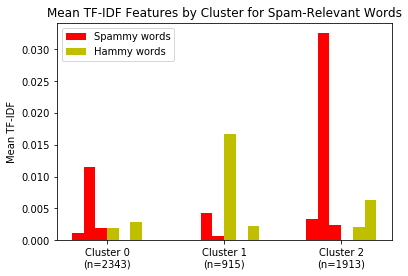

In [6]:
########################################################################
######################### Write your code here #########################
########################################################################



indice =list(vectorizer.vocabulary_.keys())
spam_indices = [indice.index('click'),indice.index('www'),indice.index('offer')]
ham_indices = [indice.index('meeting'),indice.index('attached'),indice.index('review')]



plot_spam_words_by_cluster(gmm, 3, spam_indices, ham_indices)




### Part E: Interpret results [10 points]

From the plot generated in part (d), do any of the clusters correspond to spam emails, based on the frequency of spammy and hammy words? Do any of the clusters appear to correspond to typical business emails (ham)? 

Re-run your analysis with a different choice for the number of clusters in your GMM (e.g., `n_clusters=5` or `n_clusters=2`). How does changing the number of clusters affect your results? Does one choice of `n_clusters` appear better than another for locating clusters of spam emails?

ANSWER: The cluster 2 tends to be the cluster of spam email since there are high value of TF-IDF for spammy words compared to other clusters and hammy words within cluster. Rerunning the results appear to distinguish spammy word differently. For 5 clusters, there are 3 clusters with the spammy word. While both two clusters when k = 2 is not very good for clustering as it marks all cluster to be spammy

Cluster:0 365
Cluster:1 164
Cluster:4 3992
Cluster:2 265
Cluster:3 385


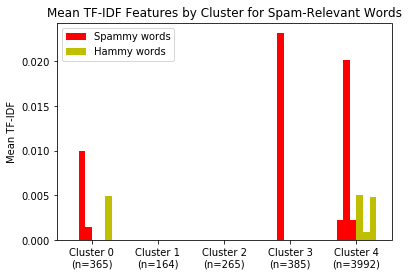

Cluster:1 1082
Cluster:0 4089


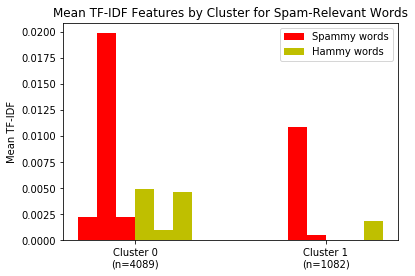

In [7]:
########################################################################
######################### Write your code here #########################
########################################################################
gmm = GaussianMixture(n_components=5)
gmm = gmm.fit(X.toarray())
gmm = gmm.predict(X.toarray())
# gmm_ = np.sort(gmm.weights_)[::-1]
gmm_count = Counter()

from collections import Counter
gmm_count = Counter()

for i in gmm:
    gmm_count[i] += 1
    
for key, value in gmm_count.items():
    print(str('Cluster:') + str(key) + ' ' + str(value))
plot_spam_words_by_cluster(gmm,5, spam_indices, ham_indices)



gmm = GaussianMixture(n_components=2)
gmm = gmm.fit(X.toarray())
gmm = gmm.predict(X.toarray())
# gmm_ = np.sort(gmm.weights_)[::-1]
gmm_count = Counter()

from collections import Counter
gmm_count = Counter()

for i in gmm:
    gmm_count[i] += 1
    
for key, value in gmm_count.items():
    print(str('Cluster:') + str(key) + ' ' + str(value))
plot_spam_words_by_cluster(gmm,2, spam_indices, ham_indices)



## Question 2: Latent "Purposes" in Mobile Apps [45 points]


Think of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Part A: Load the data [0 points]

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/).

   * Download the data and unzip it into the same folder as this notebook.
   * Rename the CSV file to "android.csv".
   * Run the cells below to load the data into the notebook.

This may take up ~2GB of RAM.

In [9]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

In [10]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [11]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B: Convert each app into a "document" [0 points]

The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

In [12]:
permission_columns = list(df.columns[10:])
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
X = df_perms.as_matrix()
#del df # uncomment to free up RAM
#del df_perms # uncomment to free up RAM

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


### Part C: Downweight "stop-words" [2.5 points]

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [13]:
########################################################################
######################### Write your code here #########################
########################################################################

from sklearn.feature_extraction.text import TfidfTransformer


tf_transformer = TfidfTransformer()
tf = tf_transformer.fit_transform(X)



### Part D: Discover 10 "topics" [2.5 points]

   * Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps).
   * Feel free to understand and play around with other parameters.
   * This may take around 3 minutes to run.

In [14]:
%%time
########################################################################
######################### Write your code here #########################
########################################################################

num_topics = 10

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=num_topics, random_state=0,max_iter = 10)
lda_ = lda.fit(tf)

/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


CPU times: user 2min 30s, sys: 464 ms, total: 2min 30s
Wall time: 2min 31s


Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### Part E: List the top 10 "words" in each topic [15 points]

Do any of the topics correspond to meaningful app "purposes"? List the ones you find meaningful below:

   * Topic #i: "your interpretation"

In [15]:
########################################################################
######################### Write your code here #########################
########################################################################
from operator import itemgetter

def find_top10(row):
    a = list(lda.components_[row])
    dict_topic = dict(zip(permission_columns, a))
    sorted_dict_topic = sorted(dict_topic.items(),
                                  reverse=True,
                                  key=itemgetter(1))
    print('Topic ' + str(row+1))
    for i in range(10):
        print(str(i+1) + ':' + str(sorted_dict_topic[i]))
    print('')

    
for x in range(10):
    find_top10(x)


Topic 1
1:('Your location : coarse (network-based) location (D)', 8128.954200762977)
2:('Your location : fine (GPS) location (D)', 7659.396551787744)
3:('Network communication : full Internet access (D)', 4042.8677699595682)
4:('Network communication : view network state (S)', 2146.503405041745)
5:('Your location : access extra location provider commands (S)', 923.0249256662182)
6:('System tools : send sticky broadcast (S)', 547.5582264293174)
7:('Default : control location update notifications (S)', 187.17289650968456)
8:('Default : permission to install a location provider (S)', 43.17009155799661)
9:('Default : monitor and control all application launching (S)', 6.731820988240924)
10:('Your location : mock location sources for testing (D)', 0.10002609537959856)

Topic 2
1:('Hardware controls : control vibrator (S)', 7597.0351658656355)
2:('Network communication : full Internet access (D)', 1876.7240840232762)
3:('Network communication : view network state (S)', 1081.3557239349036)
4:

Topic1: location
Topic3: Messaging
Topic7: Network

### Part F: For each topic, list the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic [15 points]

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings may help.

In [16]:
########################################################################
######################### Write your code here #########################
########################################################################
doc_topic_dist = lda.transform(tf)
# doc_topic_dist[0]

In [17]:
for k in range(10):
    print('Cluter: ' + str(k+1))
    dict_doc_topic = {}
    for i in range(len(app_names)):
        if app_ratings[i] > 100000:
            dict_doc_topic[i] = doc_topic_dist[i,k]

    sorted_dict_doc_topic = sorted(dict_doc_topic.items(),
                                  reverse=True,
                                  key=itemgetter(1))

    for j in range(3):
        print(app_names[sorted_dict_doc_topic[j][0]] + '       prob:' + str(sorted_dict_doc_topic[j][1]))    
        
    print('')

        

Cluter: 1
Street View on Google Maps       prob:0.6616439028828873
Toss It       prob:0.39359305576035936
GasBuddy       prob:0.3919827522198529

Cluter: 2
Bubble Blast 2       prob:0.33772210191993124
Mouse Trap       prob:0.33772210191993124
Drag Racing       prob:0.33772210191993124

Cluter: 3
Angry Birds Seasons       prob:0.6247266724137952
Yoo Ninja! Free       prob:0.6247266724137952
Adobe Reader       prob:0.5499630227834643

Cluter: 4
GO SMS Pro       prob:0.770328254768739
TweetCaster for Twitter       prob:0.7695369383336934
Zynga Poker       prob:0.7542563300471357

Cluter: 5
Racing Moto       prob:0.44795076389418004
Angry Birds       prob:0.42012309763494965
Angry Birds Rio       prob:0.42012309763494965

Cluter: 6
Real BlackJack       prob:0.7163330000674184
Robo Defense FREE       prob:0.6251254484147178
SpeechSynthesis Data Installer       prob:0.5499828304345162

Cluter: 7
Seesmic (Facebook, Twitter)       prob:0.7786879462431486
Tiny Flashlight + LED       prob:0.749

### Part G: Visualize the document-topic proportion matrix in 2-D using t-SNE [10 points]

Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.

   * Use `TSNE` from `scikit-learn`.
   * Set the angle to 0.99 and init to 'PCA'. Pick any learning rate that gives you a visually pleasing result.
   * You may `fit` TSNE to a sample of the data (>1000 documents) instead of the full data.
   * Remember to call `fit_transform` to obtain your 2-D data.
   * Plot the t-SNE dimensions as a scatterplot.
   * Color each point based on its most probable topic. Make sure you include a legend (10 colors).
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

In [52]:
%%time
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,verbose =1, angle=0.99, init = 'pca',perplexity = 20, learning_rate=50)  # note: in practice you should actually play with the perplexity, learning rate, and number of iterations
tf_tsne2d = tsne.fit_transform(X[:1000])






[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.009s...
[t-SNE] Computed neighbors for 1000 samples in 0.282s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.856487
[t-SNE] Error after 1000 iterations: 0.854757
CPU times: user 12.4 s, sys: 1.66 s, total: 14.1 s
Wall time: 13.8 s


In [53]:
cluster_assignment = []
for i in doc_topic_dist:
    b = 0
    choose = 0
    for a in range(10):
        if i[a] > b:
            b = i[a]
            choose = a
    cluster_assignment.append(choose)
            
            
# cluster_assignment
            

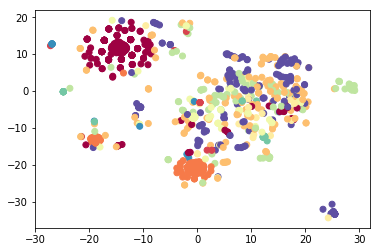

In [80]:
c = cluster_assignment[:1000]
plt.scatter(tf_tsne2d[:, 0], tf_tsne2d[:, 1],c= cluster_assignment[:1000], cmap='Spectral')
plt.show()

## Question 3: Questionnaire [5 points]

Please answer this survey after you have done this homework: https://goo.gl/forms/qi1acwKwxSfNJfjt1